Pierre El Anati

Ce notebook propose l'étude d'un jeu de données `features.csv` et de la modélisation de sa relation avec les variables `'output1_1w'` et `'output1_1m'`.
Au vue des données, l'approche adoptée a été celle d'un entraînement semi-supervisé d'un modèle **RandomForestRegressor** et d'un **ensemble de modèles** optimisé par **Autogluon** (un framework AutoML).
Les deux variables cibles ont été traitées séparement, on obtient les résultats suivants :
- **'output1_1w'**
    - Mean Squared Error: 2.77
    - R² Score: 0.49
- **'output1_1m'**
    - Mean Squared Error: 4.07
    - R² Score: 0.71

Pour aboutir à ces résultats, plusieurs approches ont été explorées (apprentissage supervisé, dépendance temporelle, régression linéaire, ainsi que diverses techniques d'imputation et de traitement des données). Cependant, pour des raisons de clarté, seule l'approche la plus performante est présentée.

De même, plusieurs visualisations ont été réalisées pour confirmer ou infirmer certaines intuitions mais ne figurent pas dans le notebook.

### /!\ Temps d'éxécution /!\ 
Le modèle Autogluon prend environ 12 minutes d'entraînement (sur CPU). Le choix réalisé a été celui de fournir le modèle le plus performant tout en ayant un temps d'entraînement raisonnable (comparé à un modèle `RandomForest optimisé` où le temps d'exécution était plus faible mais les métriques de performance significativement moins bonnes, **MSE = 3.29, R² = 0.39** pour output1_1w et **MSE = 5.99, R² Score: 0.58** pour output1_1m)

# Bibliothèques Utilisées

Ce notebook utilise les bibliothèques suivantes.


### Bibliothèques Standards
- `pandas` : Utilisé pour la manipulation et l'analyse des données.
- `numpy` : Utilisé pour les opérations numériques.
- `matplotlib` : Utilisé pour la visualisation des données.
- `seaborn` : Utilisé pour des visualisations statistiques avancées.
- `sklearn` : Utilisé pour le machine learning.
- `statsmodels` : Utilisé pour les modèles statistiques et les tests.

### Bibliothèques Non Standards
- `fancyimpute` : Utilisé pour l'imputation des valeurs manquantes dans les données.
- `autogluon` : Utilisé pour l'automatisation du machine learning.

Pour installer ces bibliothèques, vous pouvez utiliser le fichier `requirements.txt` fourni ou exécuter la cellule suivante :

In [22]:
# Installation des bibliothèques nécessaires
#! pip install pandas numpy matplotlib seaborn scikit-learn statsmodels fancyimpute autogluon

In [23]:
import pandas as pd
import numpy as np
from fancyimpute import IterativeImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from autogluon.tabular import TabularPredictor
import math

# Analyse exploratoire des données

In [24]:
df_1w = pd.read_csv("features.csv")

output = pd.read_csv('output.csv')

df_1w = pd.merge(df_1w, output[['Dates', 'output1_1w']], on='Dates', how='left')
target_1w = df_1w['output1_1w']
df_1w.set_index('Dates', inplace=True)

df_1w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6549 entries, 2000-01-03 to 2025-02-06
Data columns (total 61 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   feature1_1_period    6296 non-null   float64
 1   feature1_5_period    6292 non-null   float64
 2   feature1_21_period   6276 non-null   float64
 3   feature2_1_period    6307 non-null   float64
 4   feature2_5_period    6303 non-null   float64
 5   feature2_21_period   6287 non-null   float64
 6   feature3_1_period    6308 non-null   float64
 7   feature3_5_period    6304 non-null   float64
 8   feature3_21_period   6288 non-null   float64
 9   feature4_1_period    6282 non-null   float64
 10  feature4_5_period    6278 non-null   float64
 11  feature4_21_period   6262 non-null   float64
 12  feature5_1_period    6311 non-null   float64
 13  feature5_5_period    6307 non-null   float64
 14  feature5_21_period   6291 non-null   float64
 15  feature6_1_period    972 non

- Les features sont du bon dtype
- On observe plusieurs features avec un nombre de valeurs manquantes important
- Les variables cibles ont ~30% de valeurs manquantes, ce qui rend une approche semi-supervisée plus adaptée

In [25]:
df_1w.describe()

,feature1_1_period,feature1_5_period,feature1_21_period,feature2_1_period,feature2_5_period,feature2_21_period,feature3_1_period,feature3_5_period,feature3_21_period,feature4_1_period,...,feature18_1_period,feature18_5_period,feature18_21_period,feature19_1_period,feature19_5_period,feature19_21_period,feature20_1_period,feature20_5_period,feature20_21_period,output1_1w
count,6296.000000,6292.000000,6276.000000,6307.000000,6303.000000,6287.000000,6308.000000,6304.000000,6288.000000,6282.000000,...,291.000000,287.000000,271.000000,972.000000,968.000000,952.000000,995.000000,991.000000,975.000000,4605.000000
mean,0.000399,0.002015,0.008648,0.000753,0.003363,0.013818,-0.000091,0.001883,0.009371,11.166826,...,0.051237,0.401847,0.446273,-35.294239,51.056818,1703.327731,71.254271,469.137235,1878.237949,0.001207
std,0.020644,0.046107,0.096089,0.037311,0.078758,0.160082,0.049173,0.068036,0.125991,18882.053453,...,19.863126,39.024275,37.277186,22489.853578,58388.469607,111626.839557,6941.123058,18331.970785,42124.693613,2.368819
min,-0.126904,-0.211165,-0.334328,-0.259537,-0.296364,-0.524964,-3.059661,-2.679161,-2.492070,-148406.000000,...,-149.480000,-157.470000,-260.190000,-85780.000000,-159198.000000,-264838.000000,-37049.000000,-77030.000000,-171265.000000,-17.420000
25%,-0.011383,-0.026462,-0.053230,-0.019638,-0.043526,-0.086170,-0.012724,-0.027598,-0.054756,-9950.000000,...,-5.700000,-22.530000,-19.150000,-12311.000000,-38148.500000,-72920.000000,-3342.500000,-9632.000000,-22687.000000,-1.200000
50%,0.000000,0.000000,0.000000,0.000000,-0.000317,0.002382,0.001078,0.004269,0.013104,-762.500000,...,2.440000,2.620000,4.340000,-77.000000,-2888.000000,429.000000,27.000000,1427.000000,-204.000000,-0.150000
75%,0.011948,0.028858,0.062184,0.019393,0.045413,0.100799,0.013658,0.033735,0.075037,8541.750000,...,7.235000,26.785000,20.700000,12151.250000,33681.750000,58126.500000,3156.500000,10411.500000,28454.000000,1.070000
max,0.139535,0.235354,0.461134,0.464812,0.647817,0.988437,0.376623,0.990276,2.345654,169912.000000,...,127.630000,148.260000,135.650000,91250.000000,302362.000000,502255.000000,36156.000000,72741.000000,143332.000000,21.430000


# **Output 1w**

## Chargement du dataset
Les outliers ont initialement été retirés puis finalement réintroduits car en se basant sur la MSE et le R², on remarque qu'ils apportent de l'information

In [26]:
df_1w = pd.read_csv("features.csv")

output = pd.read_csv('output.csv')

df_1w = pd.merge(df_1w, output[['Dates', 'output1_1w']], on='Dates', how='left')
target_1w = df_1w['output1_1w']
df_1w.set_index('Dates', inplace=True)

#Drop features avec > 4000 nan
na_count = df_1w.isna().sum()
cols_to_drop = na_count[na_count > 4000].index
df_1w.drop(columns=cols_to_drop, inplace=True)
print('size after drop features : ', df_1w.shape)

size after drop features :  (6549, 37)


In [27]:
df_1w.drop(columns=['output1_1w'], inplace=True)
print('size after drop output : ', df_1w.shape)

size after drop output :  (6549, 36)


## Imputation
L'imputation MICE va permettre d'imputer les données de manière multivariée

In [28]:
imputer = IterativeImputer(random_state=42)

# Appliquer l'imputation MICE
data_imputed = imputer.fit_transform(df_1w)

# Convertir le tableau numpy imputé en DataFrame
df_1w_imputed = pd.DataFrame(data_imputed, columns=df_1w.columns)

# Afficher les informations sur le DataFrame imputé
print('Size after MICE imputation: ', df_1w_imputed.shape)
df_1w_imputed

Size after MICE imputation:  (6549, 36)


,feature1_1_period,feature1_5_period,feature1_21_period,feature2_1_period,feature2_5_period,feature2_21_period,feature3_1_period,feature3_5_period,feature3_21_period,feature4_1_period,...,feature10_21_period,feature11_1_period,feature11_5_period,feature11_21_period,feature12_1_period,feature12_5_period,feature12_21_period,feature13_1_period,feature13_5_period,feature13_21_period
0,0.000401,0.002089,0.008739,0.000735,0.003332,0.013858,-0.000119,0.001888,0.009417,10.897349,...,-0.001242,-0.252662,-1.219917,-4.718057,-0.000334,-0.001636,-0.006836,-0.237855,-1.210417,-4.014907
1,-0.054098,-0.051449,-0.048845,-0.007314,-0.006597,-0.002210,-0.024530,-0.024353,-0.021554,16484.000000,...,-0.011905,-0.528084,-3.302020,-12.045677,-0.085000,-0.083824,-0.110655,-0.394304,-0.919284,-7.636016
2,0.006932,0.008457,0.017271,-0.003676,-0.000208,0.012820,-0.025049,-0.016195,-0.001453,-14690.000000,...,0.002835,-0.054433,0.009767,-2.451860,0.059000,0.052266,0.057143,-0.102500,-1.775787,-3.253732
3,-0.006885,-0.004607,-0.000905,0.012915,0.014595,0.022118,-0.005219,-0.006218,-0.004368,700.000000,...,-0.003015,-0.289446,-1.463212,-5.783798,-0.059000,-0.053571,-0.071792,-0.246476,-1.231352,-4.506384
4,0.012132,0.013225,0.017043,-0.010474,-0.006039,-0.000013,-0.022599,-0.019773,-0.015113,1595.000000,...,0.002050,-0.166095,-0.155507,0.707571,0.009000,0.008656,-0.006986,-0.216181,-0.720465,-0.824391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6544,-0.006163,0.017350,0.004673,-0.000985,-0.244102,-0.162125,-0.002750,-0.028529,0.011294,-3157.000000,...,0.008500,-4.000000,-34.000000,-177.000000,-0.010200,-0.068400,-0.042400,-7.146173,-33.031297,-86.466721
6545,-0.004651,0.004695,-0.023822,0.101183,-0.093319,-0.084153,0.008686,-0.000137,0.000410,8144.000000,...,0.010500,-5.000000,-26.000000,-177.000000,0.051800,0.053900,-0.029800,-6.310534,-32.240077,-97.349773
6546,0.020768,0.022361,0.000509,-0.029535,-0.062806,-0.030113,-0.006288,-0.014505,-0.017036,8131.000000,...,0.010200,-1.000000,-18.000000,-168.000000,-0.035200,0.018800,-0.060800,-3.448021,-20.076640,-84.212427
6547,0.005086,0.015938,0.022245,0.032893,-0.049505,-0.084967,-0.022971,-0.021895,-0.034394,-6726.000000,...,0.008400,5.000000,-8.000000,-156.000000,-0.026900,-0.026700,-0.104300,-79.000000,-155.500000,-88.500000


## Traitement des features peu corrélées
Dans cette partie, on supprime les features ayant une corrélation peu significative avec la variable cible 'output1_1w'

In [29]:
df_1w_imputed['output'] = target_1w
correlation_matrix = df_1w_imputed.corr()

# Extraction des corrélations avec la variable cible 'output'
target_correlations = correlation_matrix['output'].sort_values(ascending=False)
selected_columns = target_correlations[(target_correlations >= -0.02) & (target_correlations <= 0.02)].index.tolist()
print(df_1w_imputed.shape)
df_1w_imputed.drop(columns=selected_columns, inplace=True)
df_1w_imputed.drop(columns=['output'], inplace=True)
df_1w_imputed.describe()
print(df_1w_imputed.shape)


(6549, 37)
(6549, 23)


## Traitement des features colinéaires
Dans cette cellule, on supprime les features ayant un VIF élevé afin de réduire la multicolinéarité

                Feature       VIF
0     feature1_1_period  1.279067
1     feature1_5_period  1.681286
2    feature1_21_period  1.518013
3     feature2_5_period  1.375485
4    feature2_21_period  1.396668
5     feature3_1_period  1.151161
6    feature3_21_period  1.320151
7     feature4_5_period  1.504923
8    feature4_21_period  1.420261
9     feature5_5_period  1.382571
10   feature5_21_period  1.267173
11    feature7_1_period  1.269255
12    feature7_5_period  1.429132
13    feature8_5_period  1.486992
14   feature8_21_period  1.650974
15   feature9_21_period  1.160822
16   feature10_5_period  1.687104
17  feature10_21_period  1.761531
18   feature11_1_period  4.959393
19   feature11_5_period  6.765091
20  feature11_21_period  2.535172
21  feature12_21_period  1.223488
22  feature13_21_period  1.284000


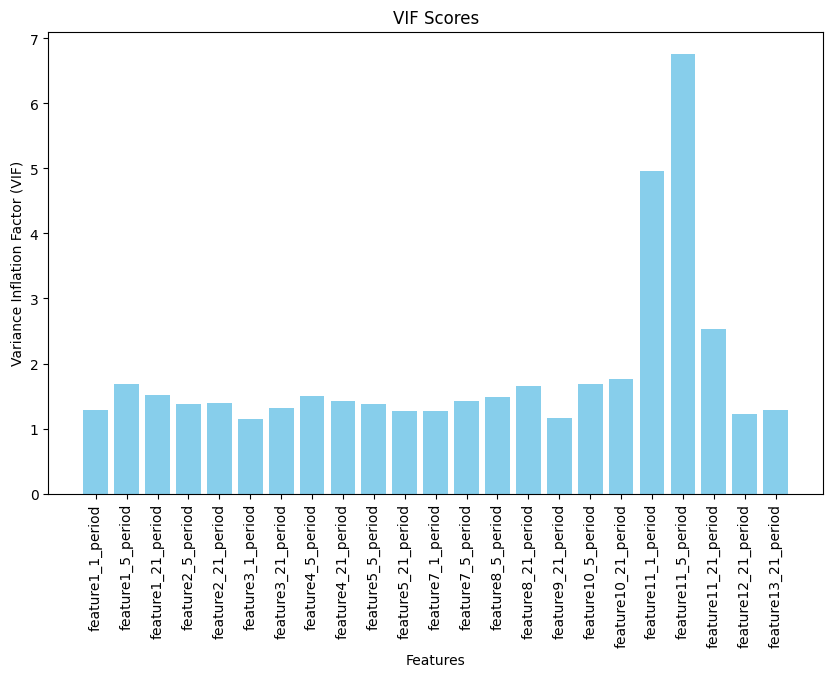

In [30]:
def calculate_vif(df):
    # Standardisation des données
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Création d'un DataFrame pour stocker les résultats du VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns

    # Calcul du VIF pour chaque feature
    vif_data["VIF"] = [variance_inflation_factor(df_scaled, i) for i in range(df_scaled.shape[1])]

    return vif_data

# Exemple d'utilisation
# Supposons que df_features est votre DataFrame contenant uniquement les features (sans la cible)
df_features = df_1w_imputed

vif_data = calculate_vif(df_features)
print(vif_data)

# Visualisation des résultats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(vif_data['Feature'], vif_data['VIF'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.title('VIF Scores')
plt.xticks(rotation=90)
plt.show()


In [31]:
print(df_1w_imputed.shape)
df_1w_imputed.drop(columns=['feature11_1_period'], inplace=True)
df_1w_imputed.drop(columns=['feature1_1_period'], inplace=True)
df_1w_imputed.drop(columns=['feature3_1_period'], inplace=True)
df_1w_imputed.drop(columns=['feature7_1_period'], inplace=True)


print(df_1w_imputed.shape)

(6549, 23)
(6549, 19)


## Entraînement semi-supervisé
- **Séparation** des données **étiquetées** et **non étiquetées**
- Entraînement d'un **premier modèle RandomForestRegressor** sur l'ensemble étiqueté
- **Etiquetage des données** non étiqutées à l'aide du modèle RandomForest créé
- **Combinaison des données** étiquetées et nouvellement étiquetées
- **Entraînement d'un ensemble de modèles** optimisé par `Autogluon` sur le dataset d'entraînement complété :
    - `Entraîne plusieurs modèles` de base en utilisant une approche de bagging reposant sur des prédictions out-of-fold ce qui permet d'implémenter une forme de validation croisée
    - `Ajuste les hyperparamètres` des modèles à l'aide d'un bayesian optimizer
    - `Combine plusieurs modèles` (par stacking ou par ensemble pondéré) pour créer un ensemble global plus robuste et performant que les modèles individuels.

`/!\ L'ensemble de test utilisé est uniquement constitué de données initialement étiquetées afin d'avoir une évaluation fiable /!\`

https://huggingface.co/autogluon/tabpfn-mix-1.0-regressor

In [ ]:

# Ajout de la cible dans le DataFrame
df_1w_imputed['output1_1w'] = target_1w

# Séparation des données étiquetées et non étiquetées
labeled_data = df_1w_imputed[df_1w_imputed['output1_1w'].notnull()]
unlabeled_data = df_1w_imputed[df_1w_imputed['output1_1w'].isnull()]

# Séparation des caractéristiques (features) et de la cible pour les données étiquetées
X_labeled = labeled_data.drop(columns=['output1_1w'])
y_labeled = labeled_data['output1_1w']

# Pour les données non étiquetées, ne conserver que les features
X_unlabeled = unlabeled_data.drop(columns=['output1_1w'])

# Division des données étiquetées en ensembles d'entraînement et de test
X_labeled_train, X_labeled_test, y_labeled_train, y_labeled_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42
)

# Etant donné les différences d'échelle entre les features, on standardise les données (moins sensibles aux outliers que la normalisation)
# Normalisation des features
scaler = StandardScaler()

# Ajustement sur l'ensemble d'entraînement et transformation
X_labeled_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_labeled_train),
    columns=X_labeled_train.columns,
    index=X_labeled_train.index
)

# Transformation de l'ensemble de test et des données non étiquetées
X_labeled_test_scaled = pd.DataFrame(
    scaler.transform(X_labeled_test),
    columns=X_labeled_test.columns,
    index=X_labeled_test.index
)
X_unlabeled_scaled = pd.DataFrame(
    scaler.transform(X_unlabeled),
    columns=X_unlabeled.columns,
    index=X_unlabeled.index
)

# Modélisation et labélisation semi-supervisée

# Entraînement initial du modèle RandomForest sur les données étiquetées normalisées
rf_model = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=30, min_samples_leaf=2)
rf_model.fit(X_labeled_train_scaled, y_labeled_train)

# Prédiction des étiquettes pour les données non étiquetées normalisées
unlabeled_predictions = rf_model.predict(X_unlabeled_scaled)
X_unlabeled_scaled['output1_1w'] = unlabeled_predictions

# Vérification des valeurs manquantes dans les prédictions
if X_unlabeled_scaled['output1_1w'].isnull().any():
    raise ValueError("Il y a des valeurs manquantes dans les prédictions des données non étiquetées.")

# Combinaison des données étiquetées (ensemble d'entraînement normalisé) et des nouvelles données étiquetées
labeled_train_scaled_with_output = pd.concat([X_labeled_train_scaled, y_labeled_train], axis=1)
combined_data = pd.concat([labeled_train_scaled_with_output, X_unlabeled_scaled])

# Ré-entraînement du modèle sur les données combinées
X_combined = combined_data.drop(columns=['output1_1w'])
y_combined = combined_data['output1_1w']

if y_combined.isnull().any():
    raise ValueError("Il y a des valeurs manquantes dans y_combined.")

rf_model.fit(X_combined, y_combined)


# Entraînement avec AutoGluon TabularPredictor

# Constitution du jeu de données d'entraînement pour AutoGluon
train_data = pd.concat([X_combined, y_combined], axis=1)

predictor = TabularPredictor(label='output1_1w', eval_metric='mean_squared_error').fit(
    train_data,
    hyperparameters={
        'GBM': {},      # LightGBM
        'XGB': {},      # XGBoost
        'RF': {},       # Random Forest
        'CAT': {},      # CatBoost
        'NN_TORCH': {}, # Neural Network
        'KNN': {},      # K-Nearest Neighbors
        'XT': {},       # Extra Trees
        'LR': {},       # Logistic Regression
        "TABPFNMIX": {}
    },
    time_limit=600,
    presets='good',
    verbosity=1,
    ds_args={'clean_up_fits': False}, 
    #ag_args_fit={"ag.max_memory_usage_ratio": 3.1},
)

# Prédiction sur l'ensemble de test avec le meilleur modèle (les données test sont normalisées)
y_pred = predictor.predict(X_labeled_test_scaled)

# Évaluation du modèle
mse = mean_squared_error(y_labeled_test, y_pred)
r2 = r2_score(y_labeled_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

#Mean Squared Error: 2.77428233254366
#R² Score: 0.485437342932054

No path specified. Models will be saved in: "AutogluonModels\ag-20250218_190754"
Preset alias specified: 'good' maps to 'good_quality'.
2025-02-18 20:08:14,630	INFO worker.py:1810 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.48 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
	Not enough memory to train TabPFNMix_BAG_L1... Skipping this model.
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.43 to avoid the error)
		To set the same value for all m

Mean Squared Error: 2.775362330392431
R² Score: 0.4852370293027697


In [33]:
# Affiche les performances des différents modèles entraînés
leaderboard = predictor.leaderboard(train_data)
leaderboard

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1_FULL,-0.000008,NaN,mean_squared_error,1.756476,NaN,9.017173,1.756476,NaN,9.017173,1,True,17
1,XGBoost_BAG_L1_FULL,-0.000882,NaN,mean_squared_error,0.231472,NaN,5.251642,0.231472,NaN,5.251642,1,True,21
2,CatBoost_BAG_L1_FULL,-0.028669,NaN,mean_squared_error,0.034018,NaN,63.159103,0.034018,NaN,63.159103,1,True,19
3,WeightedEnsemble_L2_FULL,-0.119596,NaN,mean_squared_error,2.169457,NaN,77.626159,0.021138,NaN,0.188084,2,True,22
4,WeightedEnsemble_L3_FULL,-0.236493,NaN,mean_squared_error,4.484120,NaN,122.916444,0.015629,NaN,0.364454,3,True,30
5,NeuralNetTorch_BAG_L2_FULL,-0.266500,NaN,mean_squared_error,3.363872,NaN,105.661964,0.271130,NaN,14.811809,2,True,29
6,ExtraTrees_BAG_L2_FULL,-0.275247,NaN,mean_squared_error,3.693636,NaN,93.793684,0.600893,0.495510,2.943529,2,True,26
7,ExtraTrees_BAG_L1_FULL,-0.322012,NaN,mean_squared_error,0.476117,0.568408,2.855499,0.476117,0.568408,2.855499,1,True,20
8,ExtraTrees_BAG_L1,-0.322012,-2.338707,mean_squared_error,0.535171,0.568408,2.855499,0.535171,0.568408,2.855499,1,True,5
9,RandomForest_BAG_L1_FULL,-0.322925,NaN,mean_squared_error,0.468306,0.528846,10.556581,0.468306,0.528846,10.556581,1,True,18


In [34]:
feature_importance = predictor.feature_importance(train_data)
feature_importance

,importance,stddev,p_value,n,p99_high,p99_low
feature1_5_period,2.181595,0.080429,2.212856e-07,5,2.347200,2.015990
feature1_21_period,0.782901,0.019978,5.083820e-08,5,0.824036,0.741766
feature5_5_period,0.262994,0.009365,1.926435e-07,5,0.282277,0.243710
feature2_5_period,0.187343,0.017064,8.168446e-06,5,0.222478,0.152209
feature2_21_period,0.181262,0.009926,1.074671e-06,5,0.201700,0.160825
feature10_21_period,0.180158,0.003690,2.110690e-08,5,0.187756,0.172561
feature5_21_period,0.174993,0.007253,3.533498e-07,5,0.189927,0.160059
feature11_5_period,0.170125,0.004913,8.337761e-08,5,0.180242,0.160009
feature4_5_period,0.167085,0.006877,3.435708e-07,5,0.181244,0.152925
feature9_21_period,0.160038,0.006134,2.584498e-07,5,0.172668,0.147408


## Visualisation des prédictions en fonction des valeurs réelles

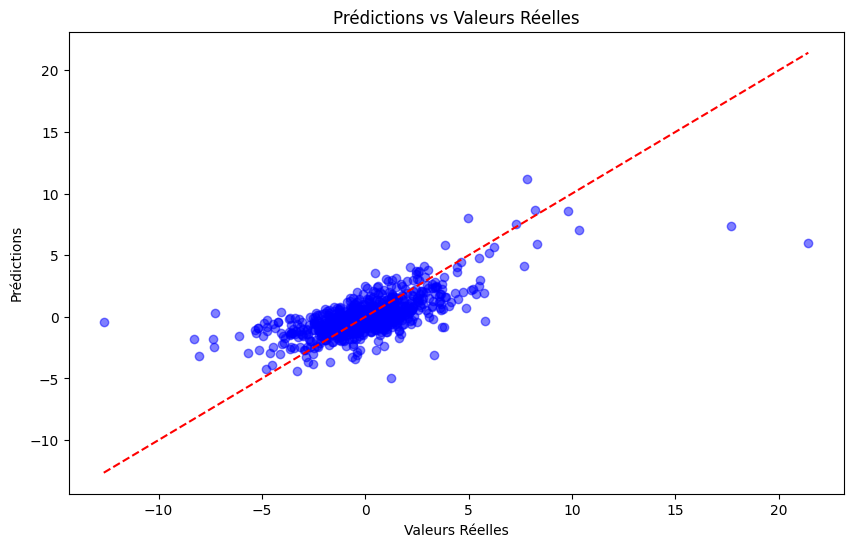

In [35]:
# Supposons que y_labeled_test contient les valeurs réelles et y_pred contient les prédictions
plt.figure(figsize=(10, 6))
plt.scatter(y_labeled_test, y_pred, alpha=0.5, color='blue')
plt.plot([min(y_labeled_test), max(y_labeled_test)], [min(y_labeled_test), max(y_labeled_test)], color='red', linestyle='--')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles')
plt.show()


# **Output 1m**

## Chargement du dataset
Les outliers ont initialement été retirés puis finalement réintroduits car en se basant sur la MSE et le R², on remarque qu'ils apportent de l'information

In [36]:
df_1m = pd.read_csv("features.csv")

output = pd.read_csv('output.csv')

df_1m = pd.merge(df_1m, output[['Dates', 'output1_1m']], on='Dates', how='left')
target_1m = df_1m['output1_1m']
df_1m.set_index('Dates', inplace=True)

#Drop features avec > 4000 nan
na_count = df_1m.isna().sum()
cols_to_drop = na_count[na_count > 4000].index
df_1m.drop(columns=cols_to_drop, inplace=True)
print('size after drop features : ', df_1m.shape)

size after drop features :  (6549, 37)


In [37]:
df_1m.drop(columns=['output1_1m'], inplace=True)
print('size after drop output : ', df_1m.shape)

size after drop output :  (6549, 36)


## Imputation

In [38]:
imputer = IterativeImputer(random_state=42)

# Appliquer l'imputation MICE
data_imputed_m = imputer.fit_transform(df_1m)

# Convertir le tableau numpy imputé en DataFrame
df_1m_imputed = pd.DataFrame(data_imputed_m, columns=df_1m.columns)

# Afficher les informations sur le DataFrame imputé
print('Size after MICE imputation: ', df_1m_imputed.shape)
df_1m_imputed

Size after MICE imputation:  (6549, 36)


,feature1_1_period,feature1_5_period,feature1_21_period,feature2_1_period,feature2_5_period,feature2_21_period,feature3_1_period,feature3_5_period,feature3_21_period,feature4_1_period,...,feature10_21_period,feature11_1_period,feature11_5_period,feature11_21_period,feature12_1_period,feature12_5_period,feature12_21_period,feature13_1_period,feature13_5_period,feature13_21_period
0,0.000401,0.002089,0.008739,0.000735,0.003332,0.013858,-0.000119,0.001888,0.009417,10.897349,...,-0.001242,-0.252662,-1.219917,-4.718057,-0.000334,-0.001636,-0.006836,-0.237855,-1.210417,-4.014907
1,-0.054098,-0.051449,-0.048845,-0.007314,-0.006597,-0.002210,-0.024530,-0.024353,-0.021554,16484.000000,...,-0.011905,-0.528084,-3.302020,-12.045677,-0.085000,-0.083824,-0.110655,-0.394304,-0.919284,-7.636016
2,0.006932,0.008457,0.017271,-0.003676,-0.000208,0.012820,-0.025049,-0.016195,-0.001453,-14690.000000,...,0.002835,-0.054433,0.009767,-2.451860,0.059000,0.052266,0.057143,-0.102500,-1.775787,-3.253732
3,-0.006885,-0.004607,-0.000905,0.012915,0.014595,0.022118,-0.005219,-0.006218,-0.004368,700.000000,...,-0.003015,-0.289446,-1.463212,-5.783798,-0.059000,-0.053571,-0.071792,-0.246476,-1.231352,-4.506384
4,0.012132,0.013225,0.017043,-0.010474,-0.006039,-0.000013,-0.022599,-0.019773,-0.015113,1595.000000,...,0.002050,-0.166095,-0.155507,0.707571,0.009000,0.008656,-0.006986,-0.216181,-0.720465,-0.824391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6544,-0.006163,0.017350,0.004673,-0.000985,-0.244102,-0.162125,-0.002750,-0.028529,0.011294,-3157.000000,...,0.008500,-4.000000,-34.000000,-177.000000,-0.010200,-0.068400,-0.042400,-7.146173,-33.031297,-86.466721
6545,-0.004651,0.004695,-0.023822,0.101183,-0.093319,-0.084153,0.008686,-0.000137,0.000410,8144.000000,...,0.010500,-5.000000,-26.000000,-177.000000,0.051800,0.053900,-0.029800,-6.310534,-32.240077,-97.349773
6546,0.020768,0.022361,0.000509,-0.029535,-0.062806,-0.030113,-0.006288,-0.014505,-0.017036,8131.000000,...,0.010200,-1.000000,-18.000000,-168.000000,-0.035200,0.018800,-0.060800,-3.448021,-20.076640,-84.212427
6547,0.005086,0.015938,0.022245,0.032893,-0.049505,-0.084967,-0.022971,-0.021895,-0.034394,-6726.000000,...,0.008400,5.000000,-8.000000,-156.000000,-0.026900,-0.026700,-0.104300,-79.000000,-155.500000,-88.500000


## Traitement des features peu corrélées

In [39]:
df_1m_imputed['output'] = target_1m
correlation_matrix_m = df_1m_imputed.corr()

# Extraction des corrélations avec la variable cible 'output'
target_correlations_m = correlation_matrix_m['output'].sort_values(ascending=False)
selected_columns_m = target_correlations_m[(target_correlations_m >= -0.02) & (target_correlations_m <= 0.02)].index.tolist()
print(df_1m_imputed.shape)
df_1m_imputed.drop(columns=selected_columns_m, inplace=True)
df_1m_imputed.drop(columns=['output'], inplace=True)
df_1m_imputed.describe()
print(df_1m_imputed.shape)


(6549, 37)
(6549, 20)


## Traitement des features colinéaires

                Feature       VIF
0     feature1_1_period  1.293679
1     feature1_5_period  1.655620
2    feature1_21_period  1.442837
3    feature2_21_period  1.044268
4     feature3_1_period  1.140761
5    feature3_21_period  1.336788
6    feature4_21_period  1.039516
7     feature5_1_period  1.039021
8    feature5_21_period  1.125043
9    feature7_21_period  1.257173
10   feature8_21_period  1.224218
11    feature9_5_period  1.074451
12   feature10_1_period  1.277866
13   feature10_5_period  1.422604
14   feature11_1_period  4.968612
15   feature11_5_period  6.775647
16  feature11_21_period  2.536142
17   feature12_5_period  1.412644
18  feature12_21_period  1.690765
19  feature13_21_period  1.277485


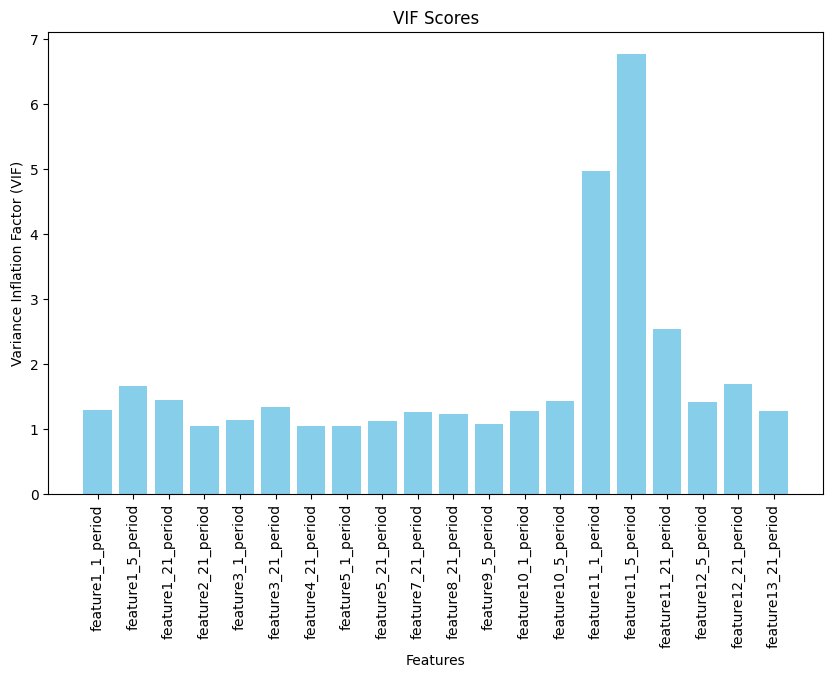

In [40]:
def calculate_vif(df):
    # Standardisation des données
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Création d'un DataFrame pour stocker les résultats du VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns

    # Calcul du VIF pour chaque feature
    vif_data["VIF"] = [variance_inflation_factor(df_scaled, i) for i in range(df_scaled.shape[1])]

    return vif_data

df_features_m = df_1m_imputed

vif_data_m = calculate_vif(df_features_m)
print(vif_data_m)

# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.bar(vif_data_m['Feature'], vif_data_m['VIF'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Variance Inflation Factor (VIF)')
plt.title('VIF Scores')
plt.xticks(rotation=90)
plt.show()


In [41]:
print(df_1m_imputed.shape)
df_1m_imputed.drop(columns=['feature11_1_period'], inplace=True)
df_1m_imputed.drop(columns=['feature1_1_period'], inplace=True)
df_1m_imputed.drop(columns=['feature3_1_period'], inplace=True)
df_1m_imputed.drop(columns=['feature10_1_period'], inplace=True)
df_1m_imputed.drop(columns=['feature12_5_period'], inplace=True)



print(df_1m_imputed.shape)

(6549, 20)
(6549, 15)


## Entraînement semi-supervisé

In [42]:
# Ajout de la cible dans le DataFrame
df_1m_imputed['output1_1m'] = target_1m

# Séparation des données étiquetées et non étiquetées
labeled_data_m = df_1m_imputed[df_1m_imputed['output1_1m'].notnull()]
unlabeled_data_m = df_1m_imputed[df_1m_imputed['output1_1m'].isnull()]

# Séparation des caractéristiques (features) et de la cible pour les données étiquetées
X_labeled_m = labeled_data_m.drop(columns=['output1_1m'])
y_labeled_m = labeled_data_m['output1_1m']

# Pour les données non étiquetées, ne conserver que les features
X_unlabeled_m = unlabeled_data_m.drop(columns=['output1_1m'])

# Division des données étiquetées en ensembles d'entraînement et de test
X_labeled_train_m, X_labeled_test_m, y_labeled_train_m, y_labeled_test_m = train_test_split(
    X_labeled_m, y_labeled_m, test_size=0.2, random_state=42
)

# Normalisation des features
scaler = StandardScaler()

# Ajustement sur l'ensemble d'entraînement et transformation
X_labeled_train_m_scaled = pd.DataFrame(
    scaler.fit_transform(X_labeled_train_m),
    columns=X_labeled_train_m.columns,
    index=X_labeled_train_m.index
)

# Transformation de l'ensemble de test et des données non étiquetées
X_labeled_test_m_scaled = pd.DataFrame(
    scaler.transform(X_labeled_test_m),
    columns=X_labeled_test_m.columns,
    index=X_labeled_test_m.index
)
X_unlabeled_m_scaled = pd.DataFrame(
    scaler.transform(X_unlabeled_m),
    columns=X_unlabeled_m.columns,
    index=X_unlabeled_m.index
)
# Modélisation et labélisation semi-supervisée

# Entraînement initial du modèle RandomForest sur les données étiquetées normalisées
rf_model_m = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=30, min_samples_leaf=2)
rf_model_m.fit(X_labeled_train_m_scaled, y_labeled_train_m)

# Prédiction des étiquettes pour les données non étiquetées normalisées
unlabeled_predictions = rf_model_m.predict(X_unlabeled_m_scaled)
X_unlabeled_m_scaled['output1_1m'] = unlabeled_predictions

# Vérification des valeurs manquantes dans les prédictions
if X_unlabeled_m_scaled['output1_1m'].isnull().any():
    raise ValueError("Il y a des valeurs manquantes dans les prédictions des données non étiquetées.")

# Combinaison des données étiquetées (ensemble d'entraînement normalisé) et des nouvelles données étiquetées
labeled_train_scaled_with_output = pd.concat([X_labeled_train_m_scaled, y_labeled_train_m], axis=1)
combined_data_m = pd.concat([labeled_train_scaled_with_output, X_unlabeled_m_scaled])

# Ré-entraînement du modèle sur les données combinées
X_combined_m = combined_data_m.drop(columns=['output1_1m'])
y_combined_m = combined_data_m['output1_1m']

if y_combined_m.isnull().any():
    raise ValueError("Il y a des valeurs manquantes dans y_combined.")

rf_model_m.fit(X_combined_m, y_combined_m)

# Entraînement avec AutoGluon TabularPredictor

# Constitution du jeu de données d'entraînement pour AutoGluon
train_data_m = pd.concat([X_combined_m, y_combined_m], axis=1)

predictor_m = TabularPredictor(label='output1_1m', eval_metric='mean_squared_error').fit(
    train_data_m,
    hyperparameters={
        'GBM': {},      # LightGBM
        'XGB': {},      # XGBoost
        'RF': {},       # Random Forest
        'CAT': {},      # CatBoost
        'NN_TORCH': {}, # Neural Network
        'KNN': {},      # K-Nearest Neighbors
        'XT': {},       # Extra Trees
        'LR': {},       # Logistic Regression
        "TABPFNMIX": {}
    },
    time_limit=600,
    presets='good',
    verbosity=1,
    ds_args={'clean_up_fits': False}, 
    #ag_args_fit={"ag.max_memory_usage_ratio": 3.1},
)

# Prédiction sur l'ensemble de test avec le meilleur modèle (les données test sont normalisées)
y_pred_m = predictor_m.predict(X_labeled_test_m_scaled)

# Évaluation du modèle
mse_m = mean_squared_error(y_labeled_test_m, y_pred_m)
r2_m = r2_score(y_labeled_test_m, y_pred_m)

print(f'Mean Squared Error: {mse_m}')
print(f'R² Score: {r2_m}')

#Mean Squared Error: 4.065992039289161
#R² Score: 0.7121563343211113

No path specified. Models will be saved in: "AutogluonModels\ag-20250218_192417"
Preset alias specified: 'good' maps to 'good_quality'.
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.48 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`
		Setting "ag.max_memory_usage_ratio" to values above 1 may result in out-of-memory errors. You may consider using a machine with more memory as a safer alternative.
	Not enough memory to train TabPFNMix_BAG_L1... Skipping this model.
	To force training the model, specify the model hyperparameter "ag.max_memory_usage_ratio" to a larger value (currently 1.0, set to >=1.48 to avoid the error)
		To set the same value for all models, do the following when calling predictor.fit: `predictor.fit(..., ag_args_fit={"ag.max_memory_usage_ratio": VALUE})`

Mean Squared Error: 4.0446414508870445
R² Score: 0.7136678059547695


In [43]:
leaderboard_m = predictor_m.leaderboard(train_data_m)
leaderboard_m

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1_FULL,-0.000017,NaN,mean_squared_error,1.769873,NaN,8.913272,1.769873,NaN,8.913272,1,True,17
1,XGBoost_BAG_L1_FULL,-0.000411,NaN,mean_squared_error,0.345056,NaN,4.693671,0.345056,NaN,4.693671,1,True,21
2,CatBoost_BAG_L1_FULL,-0.056910,NaN,mean_squared_error,0.027974,NaN,68.078179,0.027974,NaN,68.078179,1,True,19
3,WeightedEnsemble_L2_FULL,-0.234084,NaN,mean_squared_error,2.752288,NaN,81.901015,0.032921,NaN,0.162504,2,True,22
4,WeightedEnsemble_L3_FULL,-0.293426,NaN,mean_squared_error,4.797889,NaN,118.028234,0.021089,NaN,0.545316,3,True,30
5,ExtraTrees_BAG_L2_FULL,-0.325184,NaN,mean_squared_error,4.106542,NaN,95.784420,0.479112,0.496332,2.608578,2,True,26
6,RandomForest_BAG_L2_FULL,-0.382032,NaN,mean_squared_error,4.055392,NaN,103.144973,0.427962,0.649156,9.969131,2,True,24
7,NeuralNetTorch_BAG_L2_FULL,-0.411039,NaN,mean_squared_error,3.861345,NaN,102.376651,0.233915,NaN,9.200809,2,True,29
8,CatBoost_BAG_L2_FULL,-0.411388,NaN,mean_squared_error,3.635811,NaN,95.704400,0.008381,NaN,2.528558,2,True,25
9,LightGBM_BAG_L2_FULL,-0.448674,NaN,mean_squared_error,3.728306,NaN,93.600061,0.100876,NaN,0.424219,2,True,23


In [44]:
feature_importance_m = predictor_m.feature_importance(train_data_m)
feature_importance_m

,importance,stddev,p_value,n,p99_high,p99_low
feature1_21_period,7.540478,0.275729,2.141617e-07,5,8.108208,6.972748
feature5_21_period,1.154962,0.057810,7.507294e-07,5,1.273994,1.035930
feature2_21_period,1.025144,0.050734,7.174770e-07,5,1.129605,0.920682
feature3_21_period,0.997546,0.050060,7.585142e-07,5,1.100621,0.894471
feature1_5_period,0.829220,0.030319,2.140843e-07,5,0.891647,0.766793
feature11_5_period,0.764283,0.039618,8.633641e-07,5,0.845857,0.682708
feature7_21_period,0.674899,0.019374,8.140365e-08,5,0.714791,0.635007
feature11_21_period,0.661936,0.045863,2.747807e-06,5,0.756369,0.567504
feature13_21_period,0.492130,0.029780,1.601232e-06,5,0.553448,0.430812
feature12_21_period,0.388862,0.023579,1.614204e-06,5,0.437411,0.340313


## Visualisation des valeurs prédites par rapport aux valeurs réelles

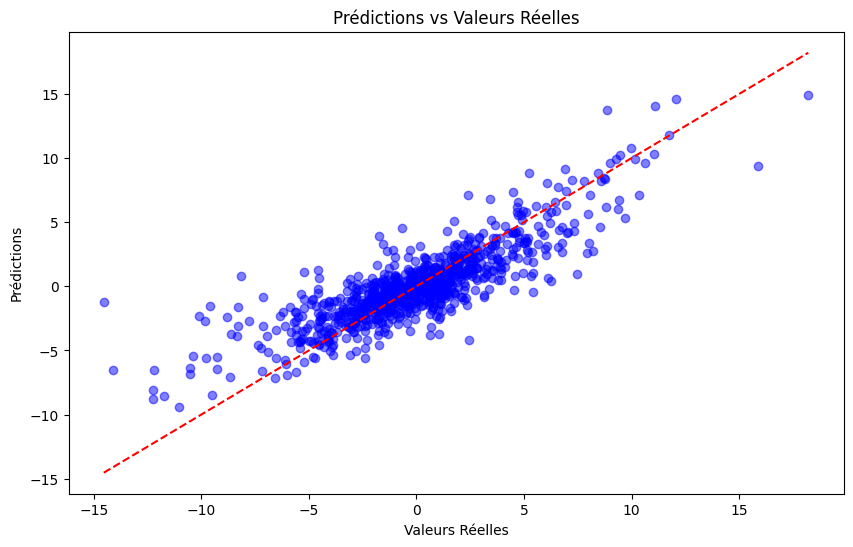

In [45]:
# Visualisation des valeurs prédites par rapport aux valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_labeled_test_m, y_pred_m, alpha=0.5, color='blue')
plt.plot([min(y_labeled_test_m), max(y_labeled_test_m)], [min(y_labeled_test_m), max(y_labeled_test_m)], color='red', linestyle='--')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.title('Prédictions vs Valeurs Réelles')
plt.show()


# Code supplémentaire
Ce code supplémentaire est à considérer uniquement si l’ensemble des modèles Autogluon est exclu en raison d’un temps d’exécution trop long.

## Output 1w

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ajout de la cible dans le DataFrame
df_1w_imputed['output1_1w'] = target_1w

# Séparation des données étiquetées et non étiquetées
labeled_data = df_1w_imputed[df_1w_imputed['output1_1w'].notnull()]

# Séparation des caractéristiques (features) et de la cible pour les données étiquetées
X_labeled = labeled_data.drop(columns=['output1_1w'])
y_labeled = labeled_data['output1_1w']

# Division des données étiquetées en ensembles d'entraînement et de test
X_labeled_train, X_labeled_test, y_labeled_train, y_labeled_test = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42
)

# Normalisation des features
scaler = StandardScaler()

# Ajustement sur l'ensemble d'entraînement et transformation
X_labeled_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_labeled_train),
    columns=X_labeled_train.columns,
    index=X_labeled_train.index
)

# Transformation de l'ensemble de test
X_labeled_test_scaled = pd.DataFrame(
    scaler.transform(X_labeled_test),
    columns=X_labeled_test.columns,
    index=X_labeled_test.index
)

# Entraînement du modèle RandomForest sur les données étiquetées normalisées
rf_model = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=30, min_samples_leaf=2)
rf_model.fit(X_labeled_train_scaled, y_labeled_train)

# Prédiction sur l'ensemble de test avec le modèle RandomForest
y_pred = rf_model.predict(X_labeled_test_scaled)

# Évaluation du modèle
mse = mean_squared_error(y_labeled_test, y_pred)
r2 = r2_score(y_labeled_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')


Mean Squared Error: 3.288062624554029
R² Score: 0.3901434540928437


## Output 1m

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ajout de la cible dans le DataFrame
df_1m_imputed['output1_1m'] = target_1m

# Séparation des données étiquetées et non étiquetées
labeled_data_m = df_1m_imputed[df_1m_imputed['output1_1m'].notnull()]

# Séparation des caractéristiques (features) et de la cible pour les données étiquetées
X_labeled_m = labeled_data_m.drop(columns=['output1_1m'])
y_labeled_m = labeled_data_m['output1_1m']

# Division des données étiquetées en ensembles d'entraînement et de test
X_labeled_train_m, X_labeled_test_m, y_labeled_train_m, y_labeled_test_m = train_test_split(
    X_labeled_m, y_labeled_m, test_size=0.2, random_state=42
)

# Normalisation des features
scaler = StandardScaler()

# Ajustement sur l'ensemble d'entraînement et transformation
X_labeled_train_m_scaled = pd.DataFrame(
    scaler.fit_transform(X_labeled_train_m),
    columns=X_labeled_train_m.columns,
    index=X_labeled_train_m.index
)

# Transformation de l'ensemble de test
X_labeled_test_m_scaled = pd.DataFrame(
    scaler.transform(X_labeled_test_m),
    columns=X_labeled_test_m.columns,
    index=X_labeled_test_m.index
)

# Entraînement du modèle RandomForest sur les données étiquetées normalisées
rf_model_m = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=30, min_samples_leaf=2)
rf_model_m.fit(X_labeled_train_m_scaled, y_labeled_train_m)

# Prédiction sur l'ensemble de test avec le modèle RandomForest
y_pred_m = rf_model_m.predict(X_labeled_test_m_scaled)

# Évaluation du modèle
mse_m = mean_squared_error(y_labeled_test_m, y_pred_m)
r2_m = r2_score(y_labeled_test_m, y_pred_m)

print(f'Mean Squared Error: {mse_m}')
print(f'R² Score: {r2_m}')


Mean Squared Error: 5.985308129320231
R² Score: 0.5762822416980474
